In [23]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Accuracy
from tensorflow.keras.losses import BinaryCrossentropy, categorical_crossentropy, sparse_categorical_crossentropy, poisson
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

import xgboost as xgb
import lightgbm as lgb

from google.colab import drive
drive.mount('/drive', force_remount=True)
seed = 21
sns.set(style='white', context='notebook', palette='deep')

Mounted at /drive


In [24]:
dataset = pd.read_csv("/drive/My Drive/dataset/dataset.csv", low_memory=False)
test = pd.read_csv("/drive/My Drive/dataset/test.csv", low_memory=False)
print(dataset.shape,test.shape)
dataset.head()

(20958, 8) (4261, 6)


,id,project_a,project_b,weight_a,weight_b,total_amount_usd,funder,quarter
0,715,https://github.com/mochajs/mocha,https://github.com/chzyer/readline,0.961581,0.038419,2681,opencollective,2016-04
1,716,https://github.com/mochajs/mocha,https://github.com/gulpjs/gulp,0.992302,0.007698,2598,opencollective,2016-04
2,717,https://github.com/chzyer/readline,https://github.com/gulpjs/gulp,0.837398,0.162602,123,opencollective,2016-04
3,718,https://github.com/chzyer/readline,https://github.com/gulpjs/gulp,0.231595,0.768405,652,opencollective,2016-07
4,719,https://github.com/chzyer/readline,https://github.com/mochajs/mocha,0.078851,0.921149,1915,opencollective,2016-07


In [25]:
test.head()

,id,project_a,project_b,total_amount_usd,funder,quarter
0,20884,https://github.com/rollup/rollup,https://github.com/webpack/webpack,29097,opencollective,2024-01
1,20885,https://github.com/rollup/rollup,https://github.com/babel/babel,26093,opencollective,2024-01
2,20886,https://github.com/rollup/rollup,https://github.com/sindresorhus/type-fest,4460,opencollective,2024-01
3,20887,https://github.com/rollup/rollup,https://github.com/inikulin/parse5,2454,opencollective,2024-01
4,20888,https://github.com/rollup/rollup,https://github.com/zloirock/core-js,13229,opencollective,2024-01


In [26]:
import pandas as pd
import requests
!pip install PyGithub
from github import Github

# Function to fetch GitHub stars
def get_github_stars(owner, repo):
    url = f"https://api.github.com/repos/{owner}/{repo}"
    response = requests.get(url)
    data = response.json()
    return data.get("stargazers_count", 0)

# Function to extract owner and repo from URL
def extract_owner_repo(url):
    parts = url.split('/')
    return parts[-2], parts[-1]

# Initialize new columns
dataset['stars_a'] = 0
dataset['stars_b'] = 0

# Fetch stars and comments
for index, row in dataset.iterrows():
    owner_a, repo_a = extract_owner_repo(row['project_a'])
    owner_b, repo_b = extract_owner_repo(row['project_b'])

    dataset.at[index, 'stars_a'] = get_github_stars(owner_a, repo_a)
    dataset.at[index, 'stars_b'] = get_github_stars(owner_b, repo_b)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 11177, number of used features: 3
[LightGBM] [Info] Start training from score 0.489132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: 

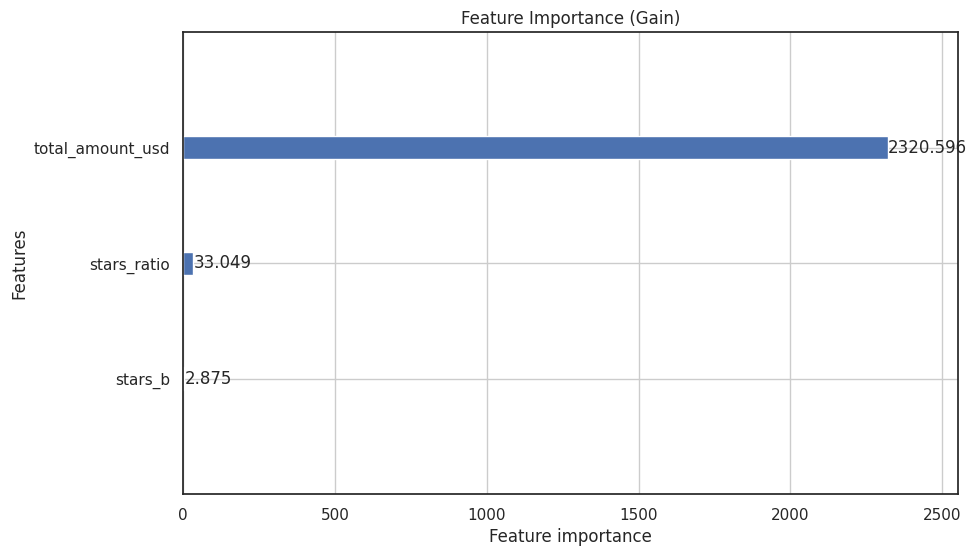

Submission created successfully


In [27]:
# ========================
#       IMPORTS
# ========================
!pip install category_encoders # Make sure this cell is run to install the package
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder # Then you can import from category_encoders
from sklearn.utils.extmath import randomized_svd
import numpy as np
import matplotlib.pyplot as plt  # Add this at the top with other imports

# ========================
#   DATA PREPARATION
# ========================
# Load your dataset and test data here
# dataset = pd.read_csv(...)
# test = pd.read_csv(...)

# Feature Selection
X = dataset.drop(['id', 'weight_a', 'weight_b', 'funder', 'quarter'], axis=1)
y = dataset['weight_a']
# Include only GitHub stars
X = X[['project_a', 'project_b', 'total_amount_usd', 'stars_a', 'stars_b']]

#TEST DATA


# Calculate 'stars_a' and 'stars_b' for the test DataFrame
# Initialize new columns
# Create a temporary DataFrame to store original 'project_a', 'project_b', 'stars_a', 'stars_b' for test data
temp_df_test = pd.DataFrame(index=test.index)  # Create empty DataFrame with same index
temp_df_test['stars_a'] = 0
temp_df_test['stars_b'] = 0

# **Create a copy of the test DataFrame with original URL values**
test_original_urls = dataset[['project_a', 'project_b']][dataset.index.isin(test.index)].copy()

# Fetch stars and comments using original 'project_a', 'project_b' values from test_original_urls
for index, row in test_original_urls.iterrows():  # Iterating through test_original_urls DataFrame
    owner_a, repo_a = extract_owner_repo(row['project_a'])  # Using original 'project_a'
    owner_b, repo_b = extract_owner_repo(row['project_b'])  # Using original 'project_b'

    temp_df_test.at[index, 'stars_a'] = get_github_stars(owner_a, repo_a)
    temp_df_test.at[index, 'stars_b'] = get_github_stars(owner_b, repo_b)

# Merge the 'stars_a', 'stars_b' columns back into the test DataFrame
test = test.merge(temp_df_test[['stars_a', 'stars_b']], left_index=True, right_index=True)

# ========================
#  FEATURE ENGINEERING
# ========================
# Create interaction features
X['stars_ratio'] = X['stars_a'] / (X['stars_b'] + 1e-6)
test['stars_ratio'] = test['stars_a'] / (test['stars_b'] + 1e-6)

# Add these features before Target Encoding
X['log_stars_diff'] = np.log1p(X['stars_a']) - np.log1p(X['stars_b'])
test['log_stars_diff'] = np.log1p(test['stars_a']) - np.log1p(test['stars_b'])

# ========================
#    TARGET ENCODING
# ========================
categorical_features = ['project_a', 'project_b']
te = TargetEncoder()

# Fit-transform on training data
X[categorical_features] = te.fit_transform(X[categorical_features], y)

# Transform test data
test[categorical_features] = te.transform(test[categorical_features])

# ========================
#   TRAIN-TEST SPLIT
# ========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ========================
#  HYPERPARAMETER TUNING
# ========================
# (Optional) Uncomment to use grid search

param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.02],
    'lambda_l1': [0.01, 0.1]
}

gbm = lgb.LGBMRegressor(objective='regression')
grid = GridSearchCV(gbm, param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
best_params = grid.best_params_
print("Best Hyperparameters:", best_params)

# ========================
#    MODEL TRAINING
# ========================
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 63,
    'max_depth': 7,
    'min_data_in_leaf': 150,
    'lambda_l1': 0.1,
    'lambda_l2': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1
}

model = lgb.train(
    best_params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=2000,
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=100)] # Pass early_stopping as a callback
)

# ========================
#   FEATURE IMPORTANCE   # <--- ADD THIS NEW SECTION
# ========================


print("\nFeature Importance Analysis:")
lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(10, 6))
plt.title('Feature Importance (Gain)')
plt.show()

# ========================
#    POST-PROCESSING (REVISED)
# ========================
import numpy as np
from scipy.optimize import minimize

def compute_global_scores(df):
    """Computes globally consistent scores using pairwise comparison data."""
    projects = pd.unique(np.concatenate([df['project_a'], df['project_b']]))
    project_ids = {p: i for i, p in enumerate(projects)}
    n = len(projects)

    # Create pairwise comparison matrix
    comparison_counts = np.zeros((n, n))
    for _, row in df.iterrows():
        i = project_ids[row['project_a']]
        j = project_ids[row['project_b']]
        comparison_counts[i, j] += row['weight_a']
        comparison_counts[j, i] += (1 - row['weight_a'])

    # Bradley-Terry optimization
    def negative_log_likelihood(scores):
        return -np.sum(
        comparison_counts * (scores[:, None] - np.logaddexp(scores[:, None], scores[None, :]))
    )

    # Initialize scores and optimize
    initial_scores = np.zeros(n)
    result = minimize(negative_log_likelihood, initial_scores, method='L-BFGS-B')
    return pd.Series(np.exp(result.x), index=projects)

# Compute global scores using training data
project_scores = compute_global_scores(dataset[['project_a', 'project_b', 'weight_a']])

# Create blended predictions
def make_final_prediction(row):
    # Get base model prediction
    # Create a DataFrame with only the necessary features
    prediction_df = pd.DataFrame([row[['project_a', 'project_b', 'total_amount_usd', 'stars_a', 'stars_b', 'stars_ratio', 'log_stars_diff']]])

    model_pred = model.predict(prediction_df)[0]

    # Get global score prediction
    score_a = project_scores.get(row['project_a'], np.median(project_scores.values))
    score_b = project_scores.get(row['project_b'], np.median(project_scores.values))
    bt_pred = 1 / (1 + np.exp(score_b - score_a))

    # Blend predictions (70% global score, 30% model)
    return 0.7 * bt_pred + 0.3 * model_pred

test['weight_a_pred'] = test.apply(make_final_prediction, axis=1)

# Ensure minimal transitive consistency
def enforce_consistency(df):
    """Ensures basic transitivity using global scores"""
    projects = pd.unique(np.concatenate([df['project_a'], df['project_b']]))
    score_dict = project_scores.to_dict()

    for idx, row in df.iterrows():
        a, b = row['project_a'], row['project_b']
        if score_dict.get(a, 0) > score_dict.get(b, 0) and row['weight_a_pred'] < 0.5:
            df.at[idx, 'weight_a_pred'] = 0.51
        elif score_dict.get(a, 0) < score_dict.get(b, 0) and row['weight_a_pred'] > 0.5:
            df.at[idx, 'weight_a_pred'] = 0.49
    return df

test = enforce_consistency(test)


# ========================
#  SUBMISSION GENERATION
# ========================
# Ensure valid probabilities
#test['weight_a_pred'] = test['weight_a_pred'].clip(0.01, 0.99)

# Replace redundant file writes with single operation
submission = test[['id']].copy()
submission['pred'] = test['weight_a_pred'].clip(0.01, 0.99)
submission['pred'] = submission.groupby('id')['pred'].transform(lambda x: x / x.sum())
submission.to_csv('/drive/My Drive/dataset/final_submission.csv', index=False)

# Final validation
assert submission['pred'].between(0, 1).all(), "Invalid probability values detected"
assert not submission.isnull().any().any(), "NaN values in submission"

submission.to_csv('/drive/My Drive/dataset/xfinal_submission.csv', index=False)
print("Submission created successfully")